# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics  import classification_report

import matplotlib.pyplot as plt
import cv2
import copy
import glob
import random

%matplotlib inline

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


# 1. The Dataset

#### Choose to use google colab or run locally

In [3]:
COLAB = True

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r"/content/drive/My Drive/data/"
    N_SAMPLES = 100
else:
    DATA_PATH = r"./images/"
    N_SAMPLES = 10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load sample of healthy and diseased plants

In [4]:
# don't use DataLoader and ImageFolder here, since we only need the N_SAMPLES per class
# don't use random sample because somehow samples vary eventhough seed used

# just use the first 100 images per class
filelist = [
    *[(DATA_PATH + f"/Apple___healthy/image ({i}).JPG") for i in range(1, 101)],
    *[(DATA_PATH + f"/Apple___Black_rot/image ({i}).JPG") for i in range(1, 101)]
]

# load all images in filelist into tensor
X = torch.stack([transforms.ToTensor()(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)) for fname in filelist])
# X = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X) # standardize on vgg16 data
y = torch.tensor([0] * N_SAMPLES + [1] * N_SAMPLES)

#### Plot some example images for both classes

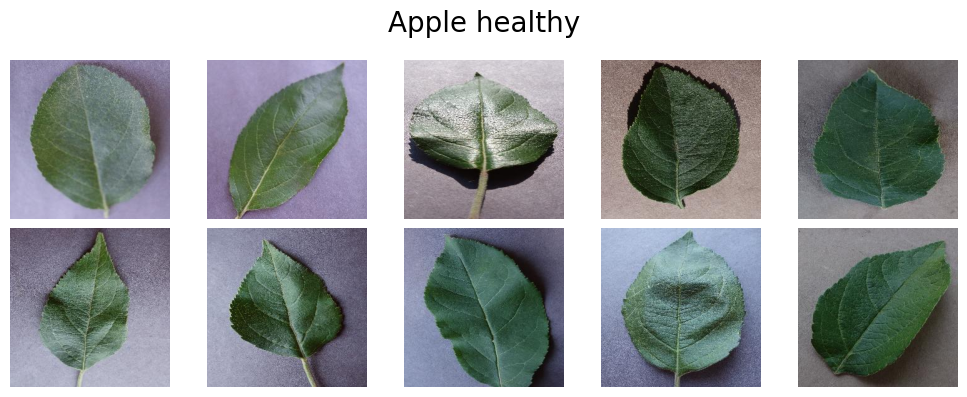

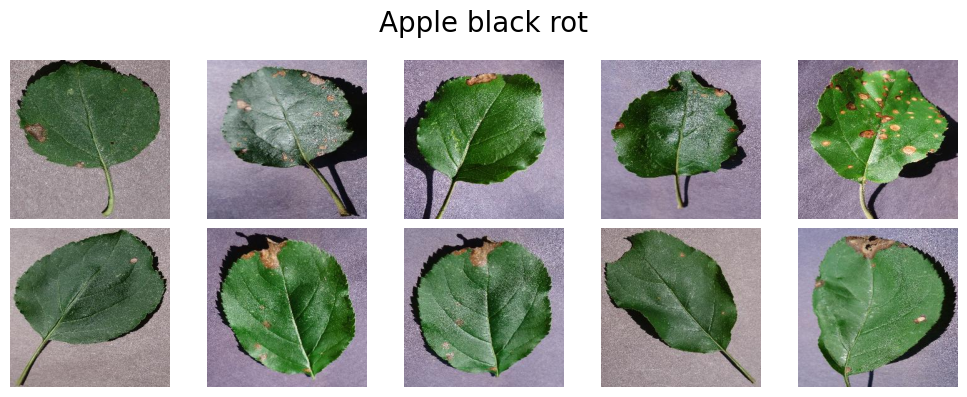

In [5]:
# plot some images in a grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle(title, fontsize=20)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()

plot_images(X[y == 0], "Apple healthy")
plot_images(X[y == 1], "Apple black rot")

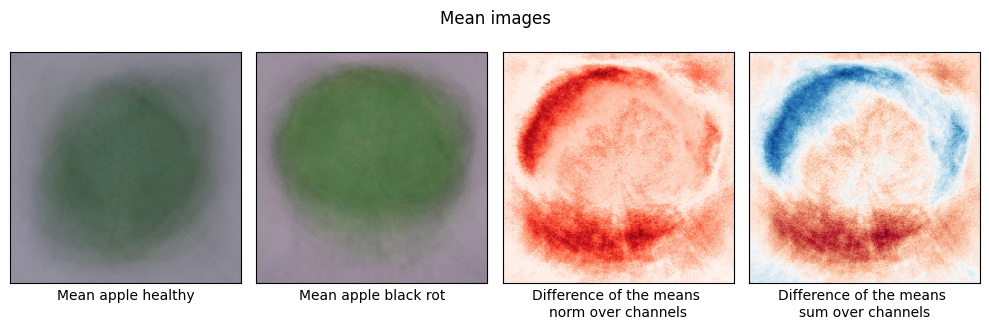

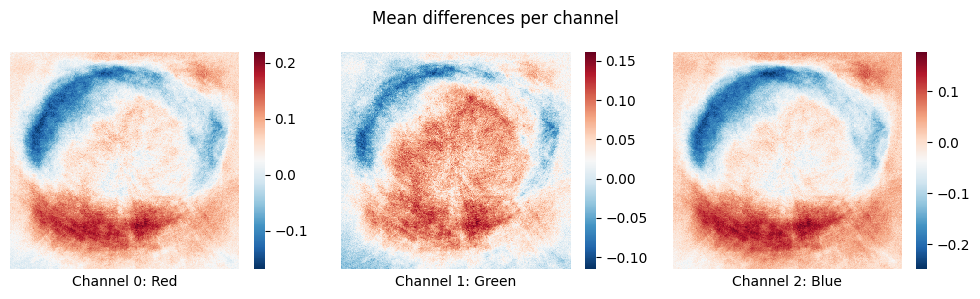

In [6]:
# Visualise mean images
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
mean0 = torch.mean(X[y == 0].permute(0, 2, 3, 1), dim=0)
mean1 = torch.mean(X[y == 1].permute(0, 2, 3, 1), dim=0)
diff = mean1 - mean0

axs[0].imshow(mean0)
axs[1].imshow(mean1)
axs[2].imshow(diff.norm(dim=2), cmap="Reds")
axs[3].imshow(diff.sum(dim=2), cmap=plt.cm.RdBu_r)

axs[0].set(xlabel="Mean apple healthy", xticks=[], yticks=[])
axs[1].set(xlabel="Mean apple black rot", xticks=[], yticks=[])
axs[2].set(xlabel="Difference of the means \nnorm over channels", xticks=[], yticks=[])
axs[3].set(xlabel="Difference of the means \nsum over channels", xticks=[], yticks=[])
plt.suptitle("Mean images")
plt.tight_layout()


# differences per channel
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
import seaborn as sns
for i, colour in enumerate(["Red", "Green", "Blue"]):
    sns.heatmap(diff[:,:,i], ax=axs[i], cmap=plt.cm.RdBu_r)
    axs[i].set(xticks=[], yticks=[], xlabel=f"Channel {i}: {colour}")
plt.suptitle("Mean differences per channel")
plt.tight_layout()

#### Observation:
The mean shape and colour of the leaves appear to differ in the two conditions. The difference in shape is not necessarily caused by the condition, therefore there might be a sampling bias. At the same time, the diseased leaves often have a deteriorated tip which might be what is reflected in the mean image and indeed be indicative of the disease.

We also calculated the pixel-wise difference of the means by subtracting the mean image of the healthy leaves ("control") from the mean image of the affected leaves. We then plotted the Euclidean norm of the difference across the colour channels, as well as the sum. We see that the upper left part and the bottom part of the rim of the diseased leaves exhibit the highest difference from the healthy leaves, followed by the other parts of a leaf contour.

For more detail, we also plotted the mean differences per channel. We can see that the body of the leaf mostly differs for the greeen channel indicating the difference in the mean colour.


# 2. Pretrained Models for Image Recognition

#### Use features of vgg16 model

In [7]:
model_features = nn.Sequential(
    *vgg16(weights=VGG16_Weights.DEFAULT).features,
    torch.nn.Flatten(start_dim=1)
)

model_features.to(device) # model = pointer, for tensors: copy on other device
model_features.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# 3. Predicting Classes from Images

#### Split data into train and test, then run through the model to get feature representation.

In [8]:
X = X.to(device)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, shuffle=True, stratify=y)

SCALE = True
if SCALE:

    # STANDARDIZE
    # X_train_mean, X_train_std = torch.mean(X_train), torch.std(X_train)
    # X_train  = (X_train-X_train_mean)/X_train_std
    # X_test  = (X_test-X_train_mean)/X_train_std


    # STANDARDIZE per channel
    X_train_channel_mean = (X_train[:,0,:,:].mean(), X_train[:,1,:,:].mean(), X_train[:,2,:,:].mean())
    X_train_channel_std = (X_train[:,0,:,:].std(), X_train[:,1,:,:].std(), X_train[:,2,:,:].std())
    X_train = transforms.Normalize(X_train_channel_mean, X_train_channel_std)(X_train)
    X_test = transforms.Normalize(X_train_channel_mean, X_train_channel_std)(X_test)


    # VGG16 SCALING ONLY
    # X_train = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_train)
    # X_test = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_test)

    # VGG16 PREPROCESSING
    # preprocessing = VGG16_Weights.IMAGENET1K_V1.transforms()
    # X_train = preprocessing(X_train)
    # X_test = preprocessing(X_test)

with torch.no_grad():
    X_train_features = model_features(X_train).to("cpu")
    X_test_features = model_features(X_test).to("cpu")
    torch.cuda.empty_cache()

print(X_train_features.shape)


torch.Size([160, 32768])


#### Calculate mean feature representation per class to get the ‘difference-of-means’ discriminant.

In [9]:
images_0_train = X_train_features[y_train == 0]
images_1_train = X_train_features[y_train == 1]
mean_0 = images_0_train.mean(dim=0)
mean_1 = images_1_train.mean(dim=0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()

print("Size of difference-of-means discriminant:", w.size())

# For standardizing purposes
#X_train_mean = X_train.mean(dim=0)
#X_train_std = X_train.std(dim=0)

Size of difference-of-means discriminant: torch.Size([32768])


#### Project data on the ‘difference-of-means’ discriminant using the dot product to score (new) instances.

In [10]:
pred_scores_train = torch.matmul(X_train_features, w)
pred_scores_test = torch.matmul(X_test_features, w)

#### Evaluate performance of ‘difference-of-means’ discriminant on the test set

AUC Score on the training set: 0.999375, number of instances of each class = 80.
AUC Score on the test set: 1.0, number of instances of each class = 20.



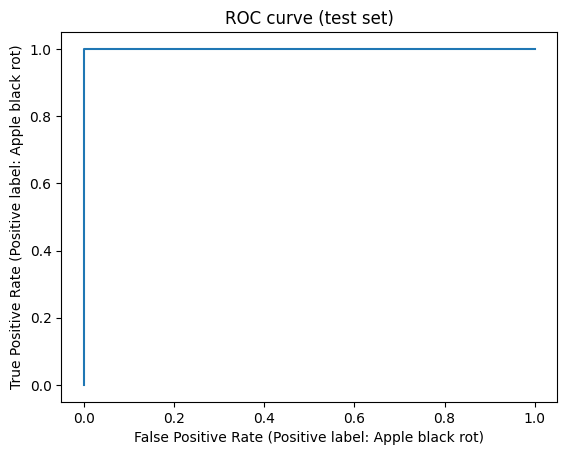

In [11]:
print(f"AUC Score on the training set: {roc_auc_score(y_train, pred_scores_train)}, number of instances of each class = {torch.sum(y_train==0).cpu()}.")
print(f"AUC Score on the test set: {roc_auc_score(y_test, pred_scores_test)}, number of instances of each class = {torch.sum(y_test==0).cpu()}.\n")

# plot a roc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_scores_test, drop_intermediate=True)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (Positive label: Apple black rot)")
plt.ylabel("True Positive Rate (Positive label: Apple black rot)")
plt.title("ROC curve (test set)")
plt.show()

#### Observation:
We evaluated the discriminating ability of the "difference-of-means" for the two classes by plotting the Receiver Operating Characteristics (ROC) curve and computing the area under the curve (AUC) on the test set.

We made sure that our test set is balanced in regard to the number of instances from each class (20), since we split the data in a stratified fashion.

This resulted in an AUC score of 0.997. As an aggregate measure of performance across all possible classification thresholds, it indicates a very good separability between the classes.

#### Optimize a threshold for maximum accuracy, then compute classification report and confusion matrix on train and test sets

Maximum training accuracy of 0.969 at threshold = 37.136

Classification report of TRAINING data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        80
           1       1.00      0.94      0.97        80

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160


Confusion Matrix


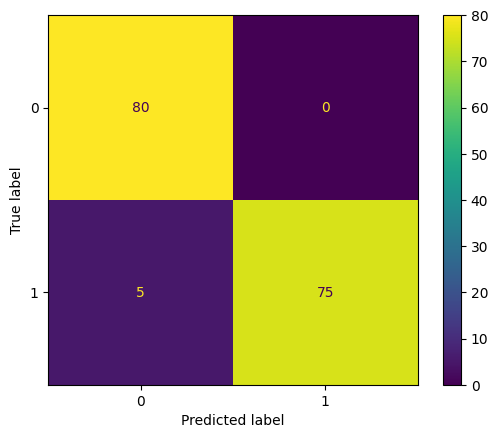



Classification report of TEST data
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40


Confusion Matrix


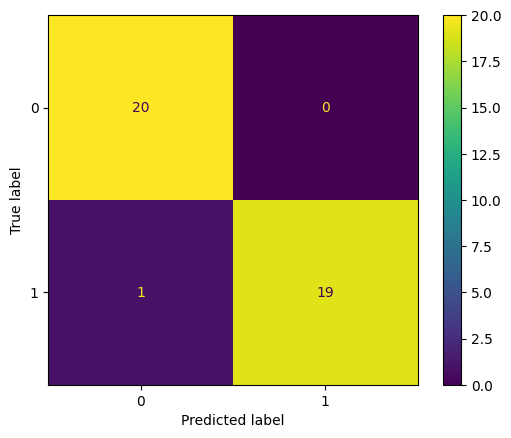

In [12]:
# get max accuracy threshold on train set
# mean_difference.norm() / 2
max_acc = 0
max_acc_threshold = 0

for t in thresholds:
  y_pred = (pred_scores_train > t).to(torch.int).to("cpu")
  acc = accuracy_score(y_train, y_pred)
  if acc > max_acc:
    max_acc = acc
    max_acc_threshold = t

print(f'Maximum training accuracy of {max_acc:.3f} at threshold = {max_acc_threshold:.3f}')


# print class. report and confusion matrix
def print_confusion_matrix(y_true, y_pred_scores, threshold):
  y_pred_classes = (y_pred_scores > threshold).to(torch.int).to("cpu")
  print(classification_report(y_true, y_pred_classes))
  print("\nConfusion Matrix")
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred_classes), display_labels=[0, 1])
  #print("Accuracy:", accuracy_score(y_true, y_pred_classes))
  disp.plot()
  plt.show()


print("\nClassification report of TRAINING data")
print_confusion_matrix(y_train, pred_scores_train, max_acc_threshold)

print("\n\nClassification report of TEST data")
print_confusion_matrix(y_test, pred_scores_test, max_acc_threshold)

# 0: "Apple healthy", 1: "Apple black rot"

#### Observation:
In order to use the "difference-of-means" discriminator as an actual classifier, we found a threshold which maximises the accuracy on the training set. Using this threshold (12.451), we computed classification reports and confusion matrices for train and test sets.
The resulting classifier performs very well: two diseased leaves get misclassified in the training set and one leaf from each class get misclassified in the test set.

#### Identify the leaves that were misclassified in the test set and save the indices for later analyses

In [13]:
# get indices of misclassification
y_pred_classes = (pred_scores_test > max_acc_threshold).to(torch.int).to("cpu")
misclassified_idx = torch.argwhere(y_pred_classes != y_test)
misclassified_idx

tensor([[26]])

# 4. Understanding the Image-Class Relation Pixel-Wise

# 4.1 Sensitivity Analysis

#### Add a linear layer representing the projection on the mean difference vector.

In [14]:
projection_layer = torch.nn.Linear(in_features=X_train_features.size()[1], out_features=1, bias=False)

# use w as the weights for the projection layer
projection_layer.weight = torch.nn.Parameter(w.to(device))

# add the projection layer to the model to get the different of means model
model_dom = model_features.append(projection_layer)

# disable training for all layers of model_dom
for param in model_dom.parameters():
    param.requires_grad = False

#### Pixel-wise explanation of the prediction for a given image:
- look at the derivative of the model w.r.t. the input pixel
- compute importance scores by computing (square) norm of gradient per pixel (over channels)
- render scores as heatmap

#### Compute an image-specific sensitivity map for the predicted score

In [15]:
def get_sensitivity(model, input_data):
    input_data = input_data.detach() # make sure that input is leaf
    input_data.requires_grad = True
    output = model(input_data)
    output.backward()
    # could use square norm, then scale and adjust vmin/vmax in imshow
    # alternatively we just use norm and default imshow settings
    sensitivity = input_data.grad.norm(dim=1).to("cpu")
    return sensitivity


def min_max_scaler(v, new_min = 0, new_max = 1):
   v_min = v.min()
   v_max = v.max()
   return (v - v_min)/(v_max - v_min)*(new_max - new_min) + new_min


def plot_sensitivity_map(sensitivity_fnc=get_sensitivity, test_set_id=36, model=model_dom):

    img = X_test[test_set_id].unsqueeze(0) # on device
    #img = img.detach() # make sure that input is leaf

    #input_data_standardized = (img - X_train_mean) / X_train_std

    # mean and std per channel from vgg16 training set
    #input_data_standardized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)

    # get sensitivity
    sensitivity = sensitivity_fnc(model, img)
    # sensitivity_norm = sensitivity_fnc(model, input_data_standardized)
    # sensitivity_norm_vgg16 = sensitivity_fnc(model, input_data_standardized_vgg16)

    # plot to images
    fig, axs = plt.subplots(2, 1, figsize=(5, 12))

    axs[0].imshow(torch.permute(img[0].detach().cpu(), (1, 2, 0)))
    # axs[0, 1].imshow(torch.permute(input_data_standardized[0].detach().cpu(), (1, 2, 0)))
    # axs[0, 2].imshow(torch.permute(input_data_standardized_vgg16[0].detach().cpu(), (1, 2, 0)))
    axs[1].imshow(sensitivity.squeeze(0), cmap="Reds")
    # axs[1, 1].imshow(sensitivity_norm.squeeze(0), cmap="Reds")
    # axs[1, 2].imshow(sensitivity_norm_vgg16.squeeze(0), cmap="Reds")

    axs[0].set_title("Input image")
    # axs[0, 1].set_title("Standardized image on train data \nclipped to [0,1]")
    # axs[0, 2].set_title("Standardized image on VGG-16 data \nclipped to [0,1]")
    axs[1].set_title("Importance scores")
    # axs[1, 1].set_title("Importance scores (using input above)")
    # axs[1, 2].set_title("Importance scores (using input above)")

    fig.suptitle(f"Sensitivity analysis for prediction of test set image with id: {test_set_id}, label: {y_test[test_set_id]}")
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()


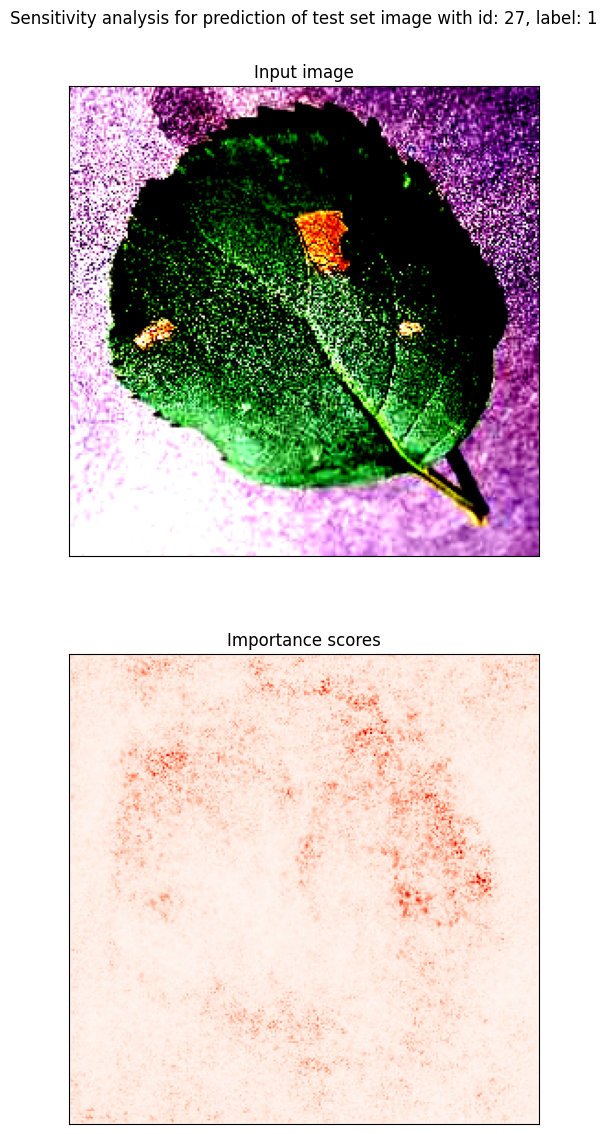

In [16]:
plot_sensitivity_map(get_sensitivity, test_set_id=27, model=model_dom)

#### Observation:
We used the local explanation method of interpreting raw gradient as importance scores for a particualr leaf image. In the sensitivity maps we can see that the pixels around the leaf contour tend to induce higher importance scores for the score prediction. However, the resulting sensitivity maps are visually noisy. The per-color-channel standardisation of the input images slightly changes the heatmap, so does the standardisation based on the ImageNet data statistics. Nevertheless, the noise is not visibly reduced thereby.

Data standardisation is common practice for image preprocessing for calssification with the goal of providing more stable and more uniform gradients. Therefore, we expected the sensitivity maps of standardised images to get less noisy, especially if we standardise based on the data set statistics. Throughout our work in the project we noticed that this was the case sometimes. The ImageNet data statistics was also having similar effect which implies that the image domain, used to train the VGG-16 network, is similar to our data domain and its statistics can also be successfully used for standardisation.

We expect that Batch normalisation layers in the model could potentially induce a similar effect of increasing the stability of the gradients and thereby somewhat reducing the noise, at least in some cases.


# 4.2 More Robust Explanations

#### Apply [SmoothGradient](https://doi.org/10.48550/arXiv.1706.03825) approach by adding Gaussian noise to the input and averaging out the importance scores

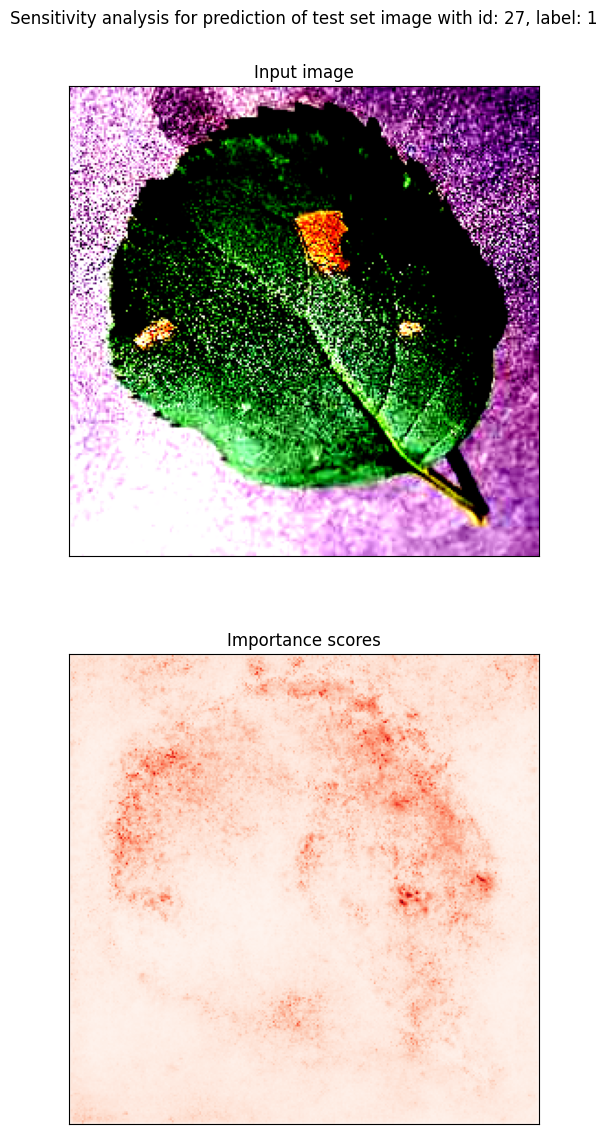

In [17]:
def get_sensitivity_smooth_gradient(model, input_data, noise_std=0.1, n=20):
    """Add Gaussian noise to the input and calculate the importance scores n times.
    Return the average sensitivity map.
    Hyperparameters: noise_std, n."""
    sensitivity = 0
    input = input_data.detach()
    for _ in range(n):
        noise = torch.randn_like(input) * noise_std
        noisy_input = (input + noise)
        noisy_input.requires_grad = True
        output = model(noisy_input)
        output.backward()
        sensitivity += noisy_input.grad.norm(dim=1).to("cpu")
    return sensitivity / n

plot_sensitivity_map(get_sensitivity_smooth_gradient, test_set_id=27, model=model_dom)

#### Observations:
Since using the raw gradient as a proxy for feature importance appears to be visually noisy, we attempted to tackle the issue by using the [SmoothGradient](https://doi.org/10.48550/arXiv.1706.03825) approach. According to the authors, the noise in sensitivity maps might be caused by essentially meaningless local variations in partial derivatives. Therefore, we applied a Gaussian kernel with SD = 0.1 in order to generate 20 random samples in a neighborhood of the input image, and averaged the resulting sensitivity map. We tuned the hyperparameters unsystematically by visual inspection.

We can observe that this approach delivers a heatmap more closely reminiscent of the shape of the leaf. As discussed earlier, the difference of leaves' shapes between the two classes might either be a result of a sampling bias or a true indicator of the disease. In both cases, the interpretation of the heatmap suggests that the shape of this particular leaf and partially its surface are the main contributors to the predicted score.

#### Create a biased convolution layer

In [18]:
class BiasedLayer(torch.nn.Module):
    def __init__(self, ConvLayer):
        super().__init__()
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.og_conv = ConvLayer

        self.biased_conv.weight = torch.nn.Parameter(self.og_conv.weight + (0.25 * torch.clip(self.og_conv.weight, min=0)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_conv.bias + (0.25 * torch.clip(self.og_conv.bias, min=0)))


    def forward(self, X):
        biased_out = self.biased_conv.forward(X)
        og_out = self.og_conv.forward(X)

        return biased_out * (og_out / biased_out).detach()

#### Test the biased layer with a tensor

In [19]:
# create Conv2d layer
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]]]]))
conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
biased_conv = BiasedLayer(conv)

# Create Artificial Input
test_input_data = torch.tensor([[[[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity for both versions
conv_output = conv(test_input_data)
conv_output.backward()
conv_sensitivity = test_input_data.grad.norm(dim=1)

test_conv_output = conv(test_input_data)
test_conv_output.backward()
test_conv_sensitivity = test_input_data.grad.norm(dim=1)

# Compare
print(f"Test conv output: {conv_output},\nTransformed conv output: {test_conv_output[0]}")
print("\nTest conv Sensitivity:\n", conv_sensitivity)
print("Transformed conv output:\n", test_conv_sensitivity)

Test conv output: tensor([[[[10.]]]], grad_fn=<ConvolutionBackward0>),
Transformed conv output: tensor([[[10.]]], grad_fn=<SelectBackward0>)

Test conv Sensitivity:
 tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
Transformed conv output:
 tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])


#### Copy previous VGG-16 difference-of-means model, but replace Conv2d with the biased layer

In [20]:
# last linear layer is not considered by default
model_dom_biased = nn.Sequential(*[BiasedLayer(l) if isinstance(l, torch.nn.Conv2d) and i > 0 else l for i,l in enumerate(model_dom.children())])
model_dom_biased.to(device)

for param in model_dom_biased.parameters():
    param.requires_grad = False

#### Compute an image-specific sensitivity map for the predicted class like before, but use the biased model

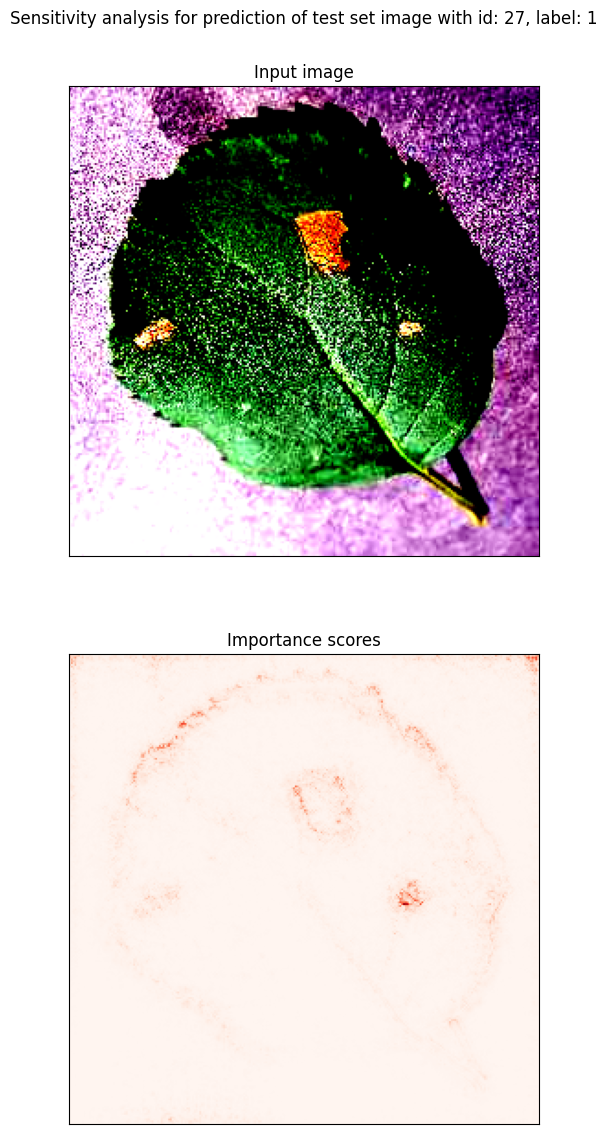

In [21]:
plot_sensitivity_map(get_sensitivity, test_set_id=27, model=model_dom_biased)

#### Observation:
The asymmetric gradient method which we applied here based on the project description is close to the [Layer-Wise Relevance Propagation (LRP)](https://doi.org/10.1371/journal.pone.0130140) approach for pixel-wise explanations. Unlike the vanilla method, it produces global explanation of the prediction in terms of the input. This potentially not only reduces the noise, but also increases the validity of using a sensitivity map for determining the pixels' importance in the classification outcome.

Biasing the gradient on the backward pass in a way that prioritises excitatory rather than inhibitory effects in the network has resulted in even less noisy explanations. The pixels delineating the upper contour of the leaf have gotten the highest importance scores as well as a few brown spots caused by the black rot. This is especially the case for the normalised images, since the gradients might tend to be more uniform. The less important pixels, on the one hand, lost their visibility in the heatmap which resulted in a very "clean" heatmap.

In terms of interpretability, putting importance on the spots of the black rot seem to be on point for a human observer. Normalising the input seemingly increases the importance attribution to these spots. Nevertheless, the upper contour of the leaf appears to be a highly important element in the image as well. Even though, in this case the upper shape of the leaf is seemingly unaffected by the disease.

#### Apply Sensitivity Analysis on several images and compare the different gradient-based approaches and different input preprocessing

In [22]:
# compare different models
def plot_sensitivity_imgs(images):
    """ images - of shape [b, C, H, W] and stored on device """

    if images.dim() == 3:
      images = images.unsqueeze(0)

    fig, axs = plt.subplots(len(images), 4, figsize=(14, len(images) * 3))

    for i, img in enumerate(images):

        # Create standardized input
        #img = img.detach() # make sure that input is leaf
        #input_data_standardized = (img - X_train_mean) / X_train_std
        #input_data_standardized = input_data_standardized.unsqueeze(0)

        # create standardized input using vgg16 data
        #input_data_standardized_vgg16 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img).unsqueeze(0)

        # Regular input
        input_data = img.unsqueeze(0)

        # get sensitivity
        sensitivity_vanilla = get_sensitivity(model_dom, input_data)
        sensitivity_smooth = get_sensitivity_smooth_gradient(model_dom, input_data)
        sensitivity_biased = get_sensitivity(model_dom_biased, input_data)
        # sensitivity_biased_norm = get_sensitivity(model_dom_biased, input_data_standardized)
        # sensitivitiy_biased_norm_vgg = get_sensitivity(model_dom_biased, input_data_standardized_vgg16)

        if len(images) > 1:
          axs[i, 0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[i, 1].imshow(sensitivity_vanilla.squeeze(0), cmap="Reds")
          axs[i, 2].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[i, 3].imshow(sensitivity_smooth.squeeze(0), cmap="Reds")
          # axs[i, 4].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          # axs[i, 5].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")
        else:
          axs[0].imshow(torch.permute(img.detach().cpu(), (1, 2, 0)))
          axs[1].imshow(sensitivity_vanilla.squeeze(0), cmap="Reds")
          axs[2].imshow(sensitivity_biased.squeeze(0), cmap="Reds")
          axs[3].imshow(sensitivity_smooth.squeeze(0), cmap="Reds")
          # axs[4].imshow(sensitivity_biased_norm.squeeze(0), cmap="Reds")
          # axs[5].imshow(sensitivitiy_biased_norm_vgg.squeeze(0), cmap="Reds")

        if (i == 0) & (len(images) > 1):
            axs[i, 0].set_title(f"Input Image")
            axs[i, 1].set_title(f"'Normal' Gradient")
            axs[i, 2].set_title(f"'Asymmetric' Gradient")
            axs[i, 3].set_title(f"'Smooth' Gradient")
            # axs[i, 4].set_title(f"'Asymmetric' Gradient (Standardized)")
            # axs[i, 5].set_title(f"'Asymmetric' Gradient \n(Standardized on VGG-16 data)")
        elif (i == 0):
            axs[0].set_title(f"Input Image")
            axs[1].set_title(f"'Normal' Gradient")
            axs[2].set_title(f"'Asymmetric' Gradient")
            axs[3].set_title(f"'Smooth' Gradient")
            # axs[4].set_title(f"'Asymmetric' Gradient (Standardized)")
            # axs[5].set_title(f"'Asymmetric' Gradient \n(Standardized on VGG-16 data)")

        #fig.suptitle(f"Gradient Sensitivity Analysis for Prediction")
    # set ticks off for all subplots
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()

#### Plot some expressive correctly classified examples form the test data set

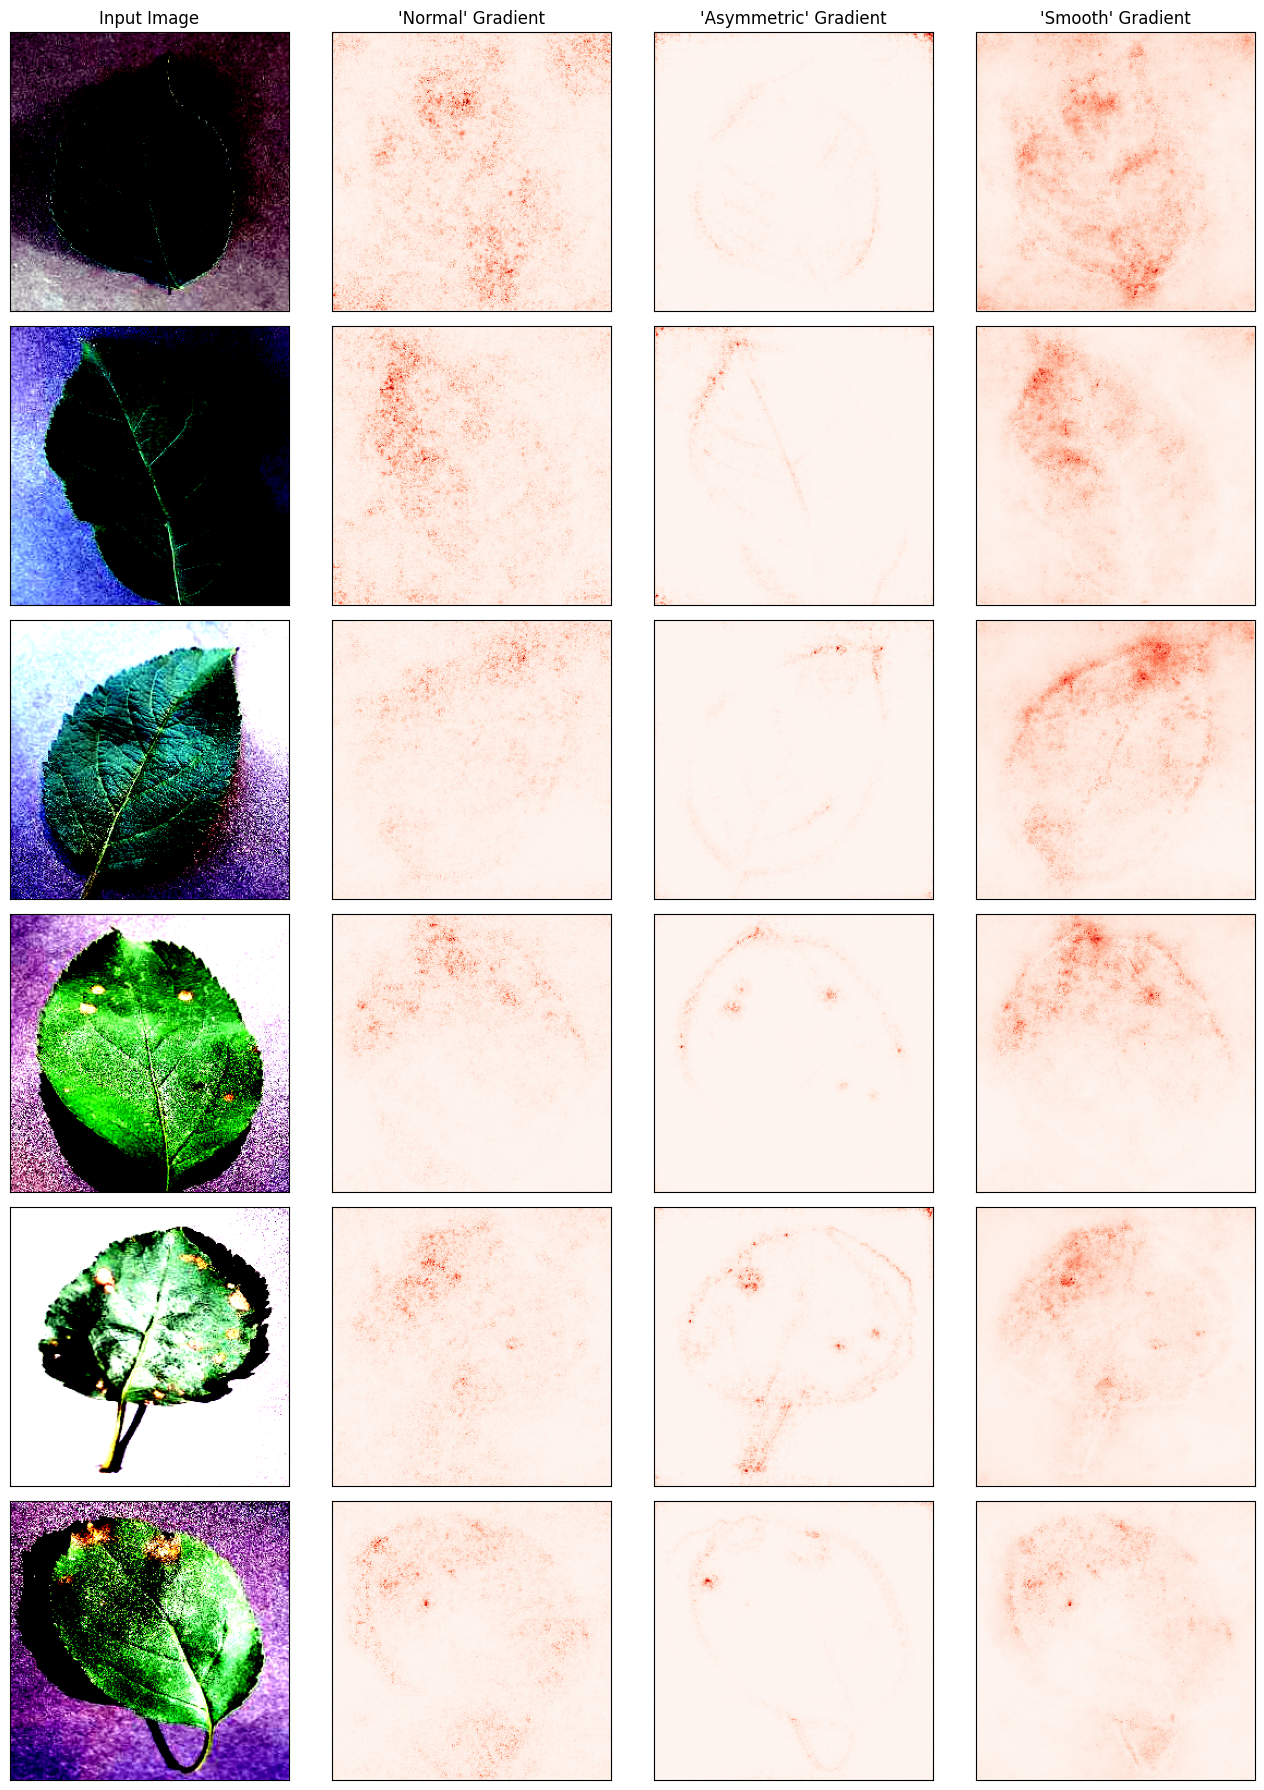

In [23]:
plot_sensitivity_imgs(X_test[[23, 28, 37, 7, 13, 14]])

#### Plot the misclassified samples from the test dataset

#### Observation:
Similar tendencies can be observed for the other images in the test set.
The local vanilla sensitivity maps are highly noisy and often uninterpretable.
The smooth gradient sensitivity maps tend to highlight the contours of the leaves in a less noisy manner. This method is local, but due to the averaging of the raw gradient, it might approximate a global sensitivity map.
The global sensitivity maps of asymmetric gradients produce much more interpretable results than the vanilla approach and more exact results than the smooth gradiens. Normalising the input seems to increase the visibility of the brown spots in the affected trees and decrese the visibility of the veins in the healthy leaves.

It is rather satisfying that often the spots affected by the black rot get highlighted. At the same time, the contour of the leaf gets high importance scores as well. This can either be due to the true causal relationship between the disease and the shape of the affected leaves or due to the sampling bias. If this is a result of sampling bias, we might have uncovered a Clever Hans Effect partially driving the high performance of the difference-of-means discriminant. Ultimately, increasing the number of samples and introducing data augmentation (rotation and flipping) might help making the mean images more similar and thereby tackling this issue.

In addition, we have noticed that the contours of the shadows of the leaves get highlighted, as well as the veins of the healthy leaves. We speculate, that the diseased leaves often get more disfigured and cast shadows or due to changes in colour, their veins are less visible. Domain knowledge might come in handy in determining whether these attributions are actually appropriate.

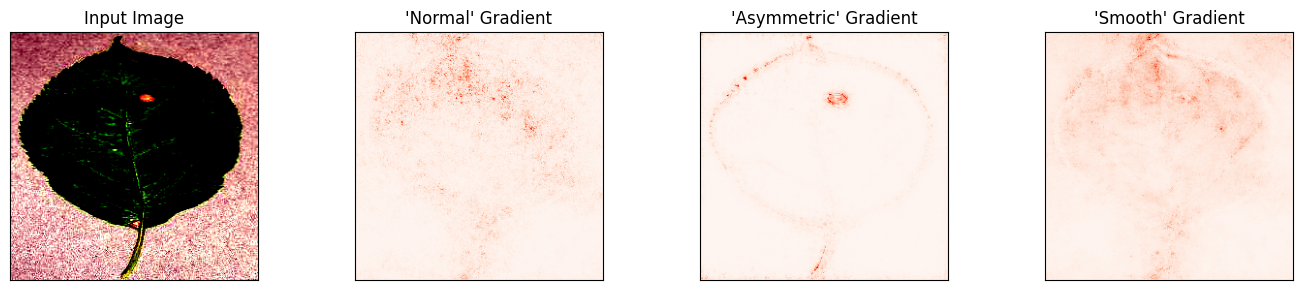

In [24]:
plot_sensitivity_imgs(X_test[misclassified_idx.squeeze()])

#### Apply sensitivity analysis on the example from the project description

#### Observation:
The first leaf in this sef it diseased, but gets classified as healthy, using our determined threshold. This happens even though the brown spots get highlighted. Given the differences in the mean shapes of the two classes, we can speculate that this leaf posesses the shape that is more common to the healthy leaves in our data set.

The second leaf is healthy, but gets classified as diseased. We can hardly interpret this result. A possible hypothsis is that this might as well be related to its shape.

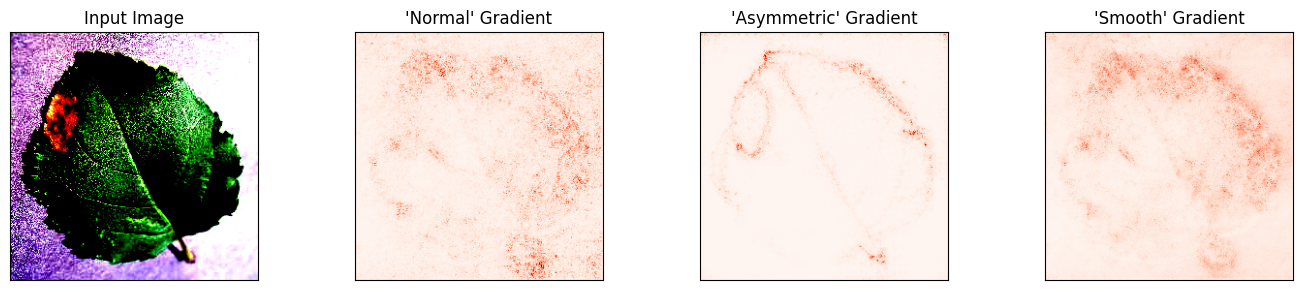

Predicted label: [1]


In [25]:
example_path = DATA_PATH + "/Apple___Black_rot/image (50).JPG"
example = transforms.ToTensor()(cv2.cvtColor(cv2.imread(example_path), cv2.COLOR_BGR2RGB)).to(device)
example = transforms.Normalize(X_train_channel_mean, X_train_channel_std)(example)
plot_sensitivity_imgs(example.unsqueeze(0))

# get prediction of example
with torch.no_grad():
  print("Predicted label:", (model_dom_biased(example.unsqueeze(0)) > max_acc_threshold).to(torch.int).cpu().numpy())


# 4.3 Discussion
### Possible sources of the mismatch between the sensitivity maps and the expectations

### Insufficiently good pretrained neural network:
- the pretext training might be not trained well enough to derive generalizable features, maybe not even for the pretext task itself
#### Possible solutions:
- check model performance of the pretrained model on an upstream task
- try to fine-tune model on the task at hand
- check if other downstream tasks exist which are suitable for this approach (derive evidence for the validity of the approach)
- experiment with other pretrained neural network models such as ResNet, AlexNet, etc.

### Improper method for extracting relevant features:
- each layer of the pretext task probably captures different aspects/features of the image
- taking the last layer may be an inaccurate choice for the downstream task at hand, i.e. detecting the apple tree disease
- we can see that the contours are captured in the sensitivity maps, which may indicate that the extracted features are related to capturing contours (or darker lines, since shadows which can be mistaken for dark areas on the leaf are also detected sometimes)
- the data domain might be too different from ours (i.e. cars and animals instead of tree leaves)
#### Possible solutions:
- try to cut of more layers to extract appropriate features
- try to fine-tune on the dataset at hand
- try to pretrain the model on more similar data

### Problems with data quality
- potential bias in data sampling
- image resolution might be low for this task, not allowing the model to capture the detailed structures or vague features
- shadows might disturb the features or introduce unwanted noise hardening the detection of structures related to the disease
#### Possible solutions:
- use image augmentation, i.e. rotation
- sample more data
- manually subsample images to balance the types of leaf shapes in both classes
- increase the resolution of the images with designated machine learning models
- remove shadows (manually or with other machine learning models)
- manually subsample images with fewer shadows

### Flawed understanding by the human of the plant disease
- disease might affect subtle features of the leaves which are hard to detect/unknown by humans
- nonlinear relationships of the features in the diseased leaves might be not perceivable by humans
#### Possible solutions:
- consult experts with domain knowledge
- try different XAI methods for better insights into the model's decisions